In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 11 09:52:03 2017

@author: ncaplar

"""


import opticspy
import astropy
import numpy as np
from astropy.io import fits

%config InlineBackend.rc = {}
import matplotlib
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

# 1d case

In [ ]:
"""Simplest thing, just to see that I can open fits file and lmfit fit a gaussian to 1d data"""

In [ ]:
data =fits.open('/media/caplarn/PFSData/PFS/Data/pfsArc-2016-11-11-0-r1.fits')

In [ ]:
scidata=data[0].data

In [ ]:
scidata_cut=scidata[2960:2970,1341:1351]

In [ ]:
from matplotlib.colors import LogNorm
plt.imshow(scidata_cut, cmap='gray')
plt.colorbar()

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(scidata_cut, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(scidata_cut, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)


In [ ]:
from lmfit import minimize, Parameters


In [ ]:
def gaussian(x, amp, cen, wid):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return (amp/(sqrt(2*pi)*wid)) * exp(-(x-cen)**2 /(2*wid**2))



In [ ]:
x=range(len(scidata_cut[5]))
y=scidata_cut[5]

In [ ]:
plt.plot(x,y)

In [ ]:
from lmfit import  Model
from numpy import sqrt, pi, exp, linspace, loadtxt
import numpy as np

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=5000, cen=5, wid=3)

print(result.fit_report())
fine_x=np.linspace(x[0], x[-1], num=50)
fine_best_fit=gaussian(fine_x,result.best_values['amp'],result.best_values['cen'],\
                       result.best_values['wid'])
plt.plot(x, y,         'bo')
plt.plot(x, result.init_fit, 'k--')
#plt.plot(x, result.best_fit, 'r-')
plt.plot(fine_x, fine_best_fit, 'r-')
plt.show()

#   <span style="color:red">2d Case now - deprecated</span>

In [226]:


"""
Run this beforhand
(caplarn@Osian:~$ setup obs_lsstSim -t sims)
caplarn@Osian:~$ setup GalSim
caplarn@Osian:~$ jupyter notebook 
"""

'\nRun this beforhand\n(caplarn@Osian:~$ setup obs_lsstSim -t sims)\ncaplarn@Osian:~$ setup GalSim\ncaplarn@Osian:~$ jupyter notebook \n'

In [ ]:
from __future__ import absolute_import, division, print_function

import lmfit
import galsim
import numpy as np
import lsst.afw



In [ ]:

z4Init=1
z4Range=(0,5)
zRange=(4,8)
r0Init=0.1
r0Range=(0,1)
centroidRange=(0,10)
fluxRelativeRange=(0,1)
zmax=8

params = lmfit.Parameters()
params.add('r0', r0Init, min=r0Range[0], max=r0Range[1])
params.add('dx', 0.0, min=centroidRange[0], max=centroidRange[1])
params.add('dy', 0.0, min=centroidRange[0], max=centroidRange[1])
image = scidata_cut
flux = float(np.sum(image))
params.add('flux', flux,
           min = fluxRelativeRange[0]*flux,
           max = fluxRelativeRange[1]*flux)
params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
for i in range(5, zmax+1):
    params.add('z{}'.format(i), 0.0, min=zRange[0], max=zRange[1])

def _chi(params):
    """Compute 'chi' image: (data - model)/sigma
    @param params  lmfit.Parameters object.
    @returns       Unraveled chi vector.
    """
    modelImg = self.constructModelImage(params)
    image = self.maskedImage.getImage().getArray()
    sigma = self.maskedImage.getVariance().getArray()
    chi = (image - modelImg)/sigma
    return chi[self.good].ravel()

def _getOptPsf(params):
    aberrations = [0, 0, 0, 0]
    for i in range(4, zmax + 1):
        aberrations.append(params['z{}'.format(i)])
    return galsim.OpticalPSF(lam = self.wavelength,
                             diam = self.aper.diam,
                             aper = self.aper,
                             aberrations = aberrations)


def constructModelImage(params=None, pixelScale=None, jacobian=None,
                        shape=None):
    """Construct model image from parameters
    @param params      lmfit.Parameters object or python dictionary with
                       param values to use, or None to use self.params
    @param pixelScale  pixel scale in arcseconds to use for model image,
                       or None to use self.pixelScale.
    @param jacobian    An optional 2x2 Jacobian distortion matrix to apply
                       to the forward model.  Note that this is relative to
                       the pixelScale above.  Use self.jacobian if this is
                       None.
    @param shape       (nx, ny) shape for model image, or None to use
                       the shape of self.maskedImage
    @returns       numpy array image
    """
    if params is None:
        params = self.params
    if shape is None:
        shape = self.maskedImage.getImage().getArray().shape
    if pixelScale is None:
        pixelScale = self.pixelScale
    if jacobian is None:
        jacobian = self.jacobian
    try:
        v = params.valuesdict()
    except AttributeError:
        v = params

    optPsf = self._getOptPsf(v)
    if 'r0' in v:
        atmPsf = galsim.Kolmogorov(lam=self.wavelength, r0=v['r0'])
        psf = galsim.Convolve(optPsf, atmPsf)
    else:
        psf = optPsf
    psf = psf.shift(v['dx'], v['dy'])*v['flux']

    wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
    modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
    return modelImg.array

In [ ]:
"""
1. Construct any kind of constructModelImage - done
2. Image with some abbeartions, made to correct input image (normalization not done)
"""

params = lmfit.Parameters()
image=scidata_cut
flux=float(np.sum(image))
params.add('flux', flux,
           min = fluxRelativeRange[0]*flux,
           max = fluxRelativeRange[1]*flux)
z4Init=0
z4Range=(0,1)
params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
zmax=11
zRange=(-1,1)
for i in range(5, zmax+1):
    params.add('z{}'.format(i), 0.1, min=zRange[0], max=zRange[1])
    
def _getOptPsf(aber_4_to_11):
    #I do not fully understand why this does not work
    #aberrations = [0, 0, 0, 0]
    #for i in range(4, zmax + 1):
    #    aberrations.append(params['z{}'.format(i)])
    
    #This line for aberrations below surely works
    aberrations_init=[0.0,0.0,0.0,0.0]
    aberrations = aberrations_init+aber_4_to_11
    
    #There is a part here related to optical properties of telescope....
    # Define the optical part of the PSF:
    # The first argument of OpticalPSF below is lambda/diam (wavelength of light / telescope
    # diameter), which needs to be in the same units used to specify the image scale.  We are using
    # arcsec for that, so we have to self-consistently use arcsec here, using the following
    # calculation:
    tel_diam = 1.          # meters
    lam = 1000              # nm    NB: don't use lambda - that's a reserved word.
    lam_over_diam = lam * 1.e-9 / tel_diam # radians
    lam_over_diam *= 206265  # arcsec
    print("wavelenght over diameter of the telescope is "+str(lam_over_diam)+" arcsec" )
    # The rest of the values should be given in units of the wavelength of the incident light.
    return galsim.OpticalPSF(lam_over_diam, aberrations = aberrations)

In [ ]:
#params
#aberrations = [0, 0, 0, 0]
#for i in range(4, zmax + 1):
#    aberrations.append(params['z{}'.format(i)])
#aberrations    

In [ ]:
#This creates opticalpsf
optPsf=_getOptPsf([0.6,0,0,0,0,0,0,0])
#We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
psf = optPsf

In [ ]:
pixelScale=geom.Angle(0.000001)
pixelScale=geom.radToArcsec(pixelScale)
print("You have set pixel scale to be "+str(pixelScale)+" arcsec")
from lsst.afw import geom
jacobian = np.eye(2, dtype=np.float64)
wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
shape=(10,10)
modelImg = psf.drawImage(
    nx = shape[0],
    ny = shape[1],
    wcs = wcs)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(modelImg.array, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(modelImg.array, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)


#  <span style="color:red">Realistic modeling now - deprecated</span>

In [ ]:
"""
3. Construct a single function which constructs model Image given some parameters constructModelImage - done
"""
from lsst.afw import geom

def _getOptPsf(params):
    #Added .value to the params[] -> params[].value
    
    #This line for aberrations below surely works
    aberrations_init=[0.0,0.0,0.0,0.0]
    aberrations = aberrations_init
    #aberrations = aberrations_init+aber_4_to_11
    for i in range(4, zmax + 1):
        aberrations.append(params['z{}'.format(i)].value)
    
    #There is a part here related to optical properties of telescope....
    # Define the optical part of the PSF:
    # The first argument of OpticalPSF below is lambda/diam (wavelength of light / telescope
    # diameter), which needs to be in the same units used to specify the image scale.  We are using
    # arcsec for that, so we have to self-consistently use arcsec here, using the following
    # calculation:
    tel_diam = 1.          # meters
    lam = 1000              # nm    NB: don't use lambda - that's a reserved word.
    lam_over_diam = lam * 1.e-9 / tel_diam # radians
    lam_over_diam *= 206265  # arcsec
    #Uncomment below to show lam_over_diam
    #print("wavelenght over diameter of the telescope is "+str(lam_over_diam)+" arcsec" )
    # The rest of the values should be given in units of the wavelength of the incident light.
    return galsim.OpticalPSF(lam_over_diam, aberrations = aberrations)

def constructModelImage_Neven(params):
    flux=float(np.sum(image))
    params.add('flux', flux,
           min = fluxRelativeRange[0]*flux,
           max = fluxRelativeRange[1]*flux)
    try:
        v = params.valuesdict()
    except AttributeError:
        v = params
    
    #This creates opticalpsf
    optPsf=_getOptPsf(params)
    #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
    psf = optPsf
    psf = psf.shift(v['dx'], v['dy'])
    #pixel scale at the moment choosen at random, made to be same to lam_over_diam
    pixelScale=geom.Angle(0.000001)
    pixelScale=geom.radToArcsec(pixelScale)
    #Uncomment below to show pixes scale
    #print("You have set pixel scale to be "+str(pixelScale)+" arcsec")
    jacobian = np.eye(2, dtype=np.float64)
    wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
    shape=np.shape(image)
    modelImg = psf.drawImage(
    nx = shape[0],
    ny = shape[1],
    wcs = wcs)
    multiplicative_factor=flux/np.sum(modelImg.array)
    return multiplicative_factor*modelImg.array

In [ ]:
"""
4. Define chi squre for our problem
"""
def _chi_Neven(params):
    """Compute 'chi' image: (data - model)/sigma
    @param params  lmfit.Parameters object.
    @returns       Unraveled chi vector.
    
    Original code below, hacking now to use pure image files
    modelImg = constructModelImage(params)
    image = maskedImage.getImage().getArray()
    sigma = maskedImage.getVariance().getArray()
    chi = (image - modelImg)/sigma
    
    """
    modelImg = constructModelImage_Neven(params)
    sigma = np.sqrt(image)
    chi = (image - modelImg)/sigma
    chi_without_nan=[]
    chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
    return chi_without_nan

In [ ]:
"""
5. Run lmfit
"""

def fit_Neven():
    """Do the fit
    @returns  result as an lmfit.MinimizerResult.
    """
    result = lmfit.minimize(_chi_Neven, params)
    return result


In [ ]:
params = lmfit.Parameters()
image=scidata_cut
flux=float(np.sum(image))
fluxRelativeRange=(0,1)
params.add('flux', flux,
           min = fluxRelativeRange[0]*flux,
           max = fluxRelativeRange[1]*flux)
z4Init=0
z4Range=(-1,1)
params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
zmax=11
zRange=(-1,1)
centroidRange=(-5,5)
params.add('dx', 0.0, min=centroidRange[0], max=centroidRange[1])
params.add('dy', 0.0, min=centroidRange[0], max=centroidRange[1])
for i in range(5, zmax+1):
    params.add('z{}'.format(i), 0.0, min=zRange[0], max=zRange[1])

In [ ]:
lmmfit_res_Neven=fit_Neven()

In [ ]:
"""
5. Show model and residuals
"""
resimg=constructModelImage_Neven(lmmfit_res_Neven.params)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(resimg, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(resimg, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)


In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(scidata_cut-resimg, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(abs(scidata_cut-resimg), cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
"""
6. Implement movable center - done, not obvious it helps

"""

In [ ]:
print(lmmfit_res_Neven.message)
print("Reduced chi square is: "+str(lmmfit_res_Neven.redchi))
lmmfit_res_Neven.params.pretty_print()


In [ ]:
lmmfit_res_Neven.flatchain

## Select donuts from the actual data

In [ ]:
data=fits.open('/media/caplarn/PFSData/PFS/Data_Sep_15/2017-08-16/v0003617/PFLAr1.fits')
scidata=data[1].data

In [ ]:
#Collumns in which there is data
pos_x_of_donuts=np.where(scidata.max(axis=0)>100)

In [ ]:
len(np.diff(pos_x_of_donuts).ravel()>10)

In [ ]:
pos_x_of_donuts[0][np.diff(pos_x_of_donuts).ravel()>10]

In [ ]:
idx = np.where((np.diff(pos_x_of_donuts).ravel()>10)!=False)[0]
idx=np.insert(idx,0,1)

In [ ]:
#This gives position of the collumns 
pos_x_of_donuts_subarray=[]
for i in range(len(idx)-1):
    pos_x_of_donuts_subarray=np.append(pos_x_of_donuts_subarray,np.mean(pos_x_of_donuts[0][(idx[i]+1):(idx[i+1]+1)]))
    pos_x_of_donuts_subarray=np.round(pos_x_of_donuts_subarray)

In [ ]:
i=1
pos_x_of_donuts[0][idx[i]:idx[i+1]]

In [ ]:
onefiber_x_position=int(pos_x_of_donuts_subarray[5])

In [ ]:
onefiber=scidata[:,onefiber_x_position-20:onefiber_x_position+20]

In [ ]:
pos_y_of_donuts=np.where(onefiber.max(axis=1)>50)
idy = np.where((np.diff(pos_y_of_donuts).ravel()>10)!=False)[0]
idy=np.insert(idy,0,1)
#This gives position of rows 
pos_y_of_donuts_subarray=[]
pos_y_of_donuts_subarray_len=[]
for i in range(len(idy)-1):
    pos_y_of_donuts_subarray=np.append(pos_y_of_donuts_subarray,np.mean(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]))
    pos_y_of_donuts_subarray_len=np.append(pos_y_of_donuts_subarray_len,len(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]))
    pos_y_of_donuts_subarray=np.round(pos_y_of_donuts_subarray)

In [ ]:
pos_y_of_donuts_subarray

In [ ]:
pos_y_of_donuts_subarray_len

In [ ]:
i=4
pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]

In [ ]:
>>> plt.hist(pos_y_of_donuts_subarray_len, bins='auto')  # arguments are passed to np.histogram
>>> plt.title("Histogram with 'auto' bins")
>>> plt.show()

In [ ]:
#Cutting above 30 pixels in this example (keep the one at 29 pixels just to see what happens)

In [ ]:
pos_y_of_donuts_subarray_single_donut=pos_y_of_donuts_subarray[pos_y_of_donuts_subarray_len<30]

In [ ]:
scidata_cuts=[[]]
for i in range(len(pos_y_of_donuts_subarray_single_donut)-1):
    single_scidata_cut=onefiber[(int(pos_y_of_donuts_subarray_single_donut[i])-20):(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
    scidata_cuts=np.append(scidata_cuts,single_scidata_cut)

In [ ]:
scidata_cuts12=np.split(scidata_cuts,12)
for i in range(len(scidata_cuts12)-1):
    scidata_cuts12[i]=scidata_cuts12[i].reshape(40,40)

In [ ]:
for ima in range(0,len(scidata_cuts12)-1):
    plt.figure()
    plt.imshow(scidata_cuts12[ima], cmap='gray')

## Create a single function that takes an image and gives a result

In [ ]:
from __future__ import absolute_import, division, print_function

import lmfit
import galsim
import numpy as np
from lsst.afw import geom
from matplotlib.colors import LogNorm

class ZernikeFitter_PSF(object):
    
    """Description comes here
    """
    def __init__(self, image, pixelScale=None,
                 jacobian=None,**kwargs):
        """
Description of parameters comes here
        """
        # I am cheating here - adding so lowest value is 0.1
        #image=image-np.min(image)+0.1
        self.image = image
        #pixel scale at the moment choosen at random, made to be same to lam_over_diam
        pixelScale=geom.Angle(0.000001)
        pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        zmax=11
        self.zmax = zmax
        self.kwargs = kwargs
    
    def initParams(self, z4Init, z4Range, zRange,
                   centroidRange, fluxRelativeRange):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        params = lmfit.Parameters()
        params.add('dx', 0.0, min=centroidRange[0], max=centroidRange[1])
        params.add('dy', 0.0, min=centroidRange[0], max=centroidRange[1])
        image = self.image
        flux = float(np.sum(image))
        self.flux=flux
        params.add('flux', flux,
                   min = fluxRelativeRange[0]*flux,
                   max = fluxRelativeRange[1]*flux)
        params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0, min=zRange[0], max=zRange[1])
        self.params = params
    
    def _getOptPsf(self, params):
        #Added .value to the params[] (i.e., changed params[]-> params[].value)
        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init
        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        #There is a part here related to optical properties of telescope....
        # Define the optical part of the PSF:
        # The first argument of OpticalPSF below is lambda/diam (wavelength of light / telescope
        # diameter), which needs to be in the same units used to specify the image scale.  We are using
        # arcsec for that, so we have to self-consistently use arcsec here, using the following
        # calculation:
        tel_diam = 1.          # meters
        lam = 1000              # nm    NB: don't use lambda - that's a reserved word.
        lam_over_diam = lam * 1.e-9 / tel_diam # radians
        lam_over_diam *= 206265  # arcsec
        #Uncomment below to show lam_over_diam
        #print("wavelenght over diameter of the telescope is "+str(lam_over_diam)+" arcsec" )
        # The rest of the values should be given in units of the wavelength of the incident light.
        return galsim.OpticalPSF(lam_over_diam, aberrations = aberrations)
    
    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])*v['flux']
        #pixel scale at the moment choosen at random, made to be same to lam_over_diam
        #pixelScale=geom.Angle(0.000001)
        #pixelScale=geom.radToArcsec(pixelScale)
        #Uncomment below to show pixes scale
        #print("You have set pixel scale to be "+str(pixelScale)+" arcsec")
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        #multiplicative_factor=np.sum(modelImg.array)
        return 1*modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print(np.mean(chi_without_nan)**2)
        return chi_without_nan
    
    def best_image_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_Neven(self):
        """Do the fit
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit")
        self.result = lmfit.minimize(self._chi_Neven, self.params, method='brute',**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)

# <span style="color:red">Running new class on a single object -theoretically done, seems to be very sensitive on initial conditions  - deprecated</span>

In [ ]:
single_image_analysis=ZernikeFitter_PSF(scidata_cut,epsfcn=0.1)

In [ ]:
single_image_analysis.initParams(z4Init=0.5,z4Range=(0,1),zRange=(-1,1),\
                                 centroidRange=(-5,5),fluxRelativeRange=(0,1))

In [ ]:
result_fit_single_image=single_image_analysis.fit_Neven()

In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(best_img, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(best_img, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(residual_img, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(residual_img, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
result_fit_single_image.params

In [ ]:
single_image_analysis.report()

In [ ]:
result_fit_single_image.init_vals

#  <span style="color:red">Running new class on a single donut  - deprecated</span>

In [ ]:
#semi-reasonable results with brute force method...

single_image_analysis=ZernikeFitter_PSF(scidata_cuts12[5])
single_image_analysis.initParams(z4Init=0.2,z4Range=(0,2),zRange=(-1,1),\
                                 centroidRange=(-5,5),fluxRelativeRange=(0,1))
result_fit_single_image=single_image_analysis.fit_Neven()
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(scidata_cuts12[5], cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(scidata_cuts12[5], cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(best_img, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(best_img, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(residual_img, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(residual_img, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
result_fit_single_image.params


In [ ]:
single_image_analysis.report()

#    <span style="color:red">Which pixels are contributing in the final image?  - deprecated</span>

In [ ]:
kinda_sigma_map=np.sqrt(scidata_cuts12[5])
map_where_chi2=(residual_img/kinda_sigma_map)**2

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(np.nan_to_num(map_where_chi2), cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(np.nan_to_num(map_where_chi2), cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
# The problem is in the innermost pixes - optical tshings

In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)

In [ ]:
result_fit_single_image.params

## Ok the problem is that I have not modeled the  pupil

In [ ]:
# This will be quite complex
# Lets first make any psf with roughly the reasonable aperature

In [ ]:
from __future__ import absolute_import, division, print_function

__all__ = ['PupilFactory_Neven', 'Pupil']

import numpy as np


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale


class PupilFactory_Neven(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupil array.
                              Note that this may be larger than the actual
                              diameter of the illuminated pupil to
                              accommodate zero-padding.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False

    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False

In [ ]:
from __future__ import absolute_import, division, print_function

from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
import numpy as np


class PFSPupilFactory(PupilFactory_Neven):
    """!Pupil obscuration function factory for PFS - work in progress.
    """
    def __init__(self, pupilSize, npix):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory_Neven.__init__(self, pupilSize, npix)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0.43, 0.43]),
                         np.array([0.43, 0.43]),
                         np.array([-0.43, -0.43]),
                         np.array([-0.43, -0.43])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle = 51.75*degrees
        alpha = strutAngle - 45.0*degrees
        unrotAngles = [90*degrees + alpha,
                       -alpha,
                       180*degrees - alpha,
                       270*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    telescopeDiameter = 8.2  # meters

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(np.arctan2(0, 1))
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        subaruRadius = self.telescopeDiameter/2

        hscFrac = 0.231  # linear fraction
        # radius of HSC camera shadow in meters
        hscRadius = hscFrac * subaruRadius

        subaruStrutThick = 0.22  # meters

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 0.00558 * 3600 / 128.9 * subaruRadius
        # Projected radius of lens obstruction in meters
        lensRadius = subaruRadius * 138./128.98

        # Focal plane location in degrees
        hscPlateScale = 0.168  # arcsec/pixel
        thetaX = point.getX() * hscPlateScale / 3600
        thetaY = point.getY() * hscPlateScale / 3600

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        # Cut outer edge where L1 is too small
        lensX = thetaX * lensRate
        lensY = thetaY * lensRate
        self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil

In [ ]:
HscPupil=PFSPupilFactory(5,10)

In [ ]:
iluminated.shape[0]

In [ ]:
iluminated=np.ones((4,4),dtype=np.int16)
diam=1
pupil=Pupil(iluminated,1,0.1)

aper_test = galsim.Aperture(
            diam = diam,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = pupil.size)

In [ ]:
def _getOptPsf(params):
    #Added .value to the params[] -> params[].value
    
    #This line for aberrations below surely works
    aberrations_init=[0.0,0.0,0.0,0.0]
    aberrations = aberrations_init
    #aberrations = aberrations_init+aber_4_to_11
    for i in range(4, zmax + 1):
        aberrations.append(params['z{}'.format(i)].value)
    
    #There is a part here related to optical properties of telescope....
    # Define the optical part of the PSF:
    # The first argument of OpticalPSF below is lambda/diam (wavelength of light / telescope
    # diameter), which needs to be in the same units used to specify the image scale.  We are using
    # arcsec for that, so we have to self-consistently use arcsec here, using the following
    # calculation:
    tel_diam = 1.          # meters
    lam = 1000              # nm    NB: don't use lambda - that's a reserved word.
    lam_over_diam = lam * 1.e-9 / tel_diam # radians
    lam_over_diam *= 206265  # arcsec
    #Uncomment below to show lam_over_diam
    #print("wavelenght over diameter of the telescope is "+str(lam_over_diam)+" arcsec" )
    # The rest of the values should be given in units of the wavelength of the incident light.
    return galsim.OpticalPSF(lam=lam,diam=tel_diam, aberrations = aberrations,aper=aper_test)

In [ ]:
import galsim
from galsim import phase_psf

zmax=11
_getOptPsf(result_fit_single_image.params)

In [ ]:
dir(HscPupil)

#  <span style="color:red">Ok, now the class with some aperature  - deprecated</span>

In [1]:
"""
Created on Tue Sep 19 12:24:03 2017

@author: ncaplar

"""


'\nCreated on Tue Sep 19 12:24:03 2017\n\n@author: ncaplar\n\n'

In [4]:
from __future__ import absolute_import, division, print_function

import lmfit
import galsim
import numpy as np
import lsst.afw
import astropy

from astropy.io import fits
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D
from matplotlib.colors import LogNorm

import matplotlib
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 22})
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

## Select donuts from the actual data

In [136]:
data=fits.open('/media/caplarn/PFSData/PFS/Data_Sep_15/2017-08-16/v0003617/PFLAr1.fits')
scidata=data[1].data
#data=fits.open('/home/caplarn/Downloads/pfsArc-2016-11-11-0-r1.fits')
#scidata=data[0].data

In [137]:
#Collumns in which there is data
pos_x_of_donuts=np.where(scidata.max(axis=0)>100)
idx = np.where((np.diff(pos_x_of_donuts).ravel()>10)!=False)[0]
idx=np.insert(idx,0,1)
#This gives position of the collumns 
pos_x_of_donuts_subarray=[]
for i in range(len(idx)-1):
    pos_x_of_donuts_subarray=np.append(pos_x_of_donuts_subarray,np.mean(pos_x_of_donuts[0][(idx[i]+1):(idx[i+1]+1)]))
    pos_x_of_donuts_subarray=np.round(pos_x_of_donuts_subarray)
onefiber_x_position=int(pos_x_of_donuts_subarray[5])    
onefiber=scidata[:,onefiber_x_position-20:onefiber_x_position+20]
pos_y_of_donuts=np.where(onefiber.max(axis=1)>50)
idy = np.where((np.diff(pos_y_of_donuts).ravel()>10)!=False)[0]
idy=np.insert(idy,0,1)
#This gives position of rows 
pos_y_of_donuts_subarray=[]
pos_y_of_donuts_subarray_len=[]
for i in range(len(idy)-1):
    pos_y_of_donuts_subarray=np.append(pos_y_of_donuts_subarray,np.mean(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]))
    pos_y_of_donuts_subarray_len=np.append(pos_y_of_donuts_subarray_len,len(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]))
    pos_y_of_donuts_subarray=np.round(pos_y_of_donuts_subarray)

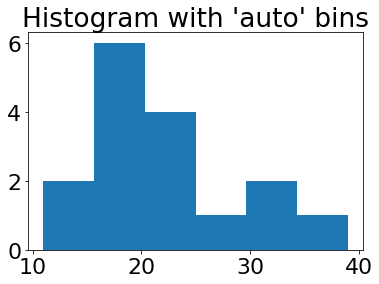

In [138]:
>>> plt.hist(pos_y_of_donuts_subarray_len, bins='auto')  # arguments are passed to np.histogram
>>> plt.title("Histogram with 'auto' bins")
>>> plt.show()

In [139]:
#Cutting above 30 pixels in this example (keep the one at 29 pixels just to see what happens)

In [140]:
pos_y_of_donuts_subarray_single_donut=pos_y_of_donuts_subarray[pos_y_of_donuts_subarray_len<30]

In [141]:
scidata_cuts=[[]]
for i in range(len(pos_y_of_donuts_subarray_single_donut)-1):
    single_scidata_cut=onefiber[(int(pos_y_of_donuts_subarray_single_donut[i])-20):(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
    scidata_cuts=np.append(scidata_cuts,single_scidata_cut)

In [142]:
scidata_cuts12=np.split(scidata_cuts,12)
for i in range(len(scidata_cuts12)-1):
    scidata_cuts12[i]=scidata_cuts12[i].reshape(40,40)

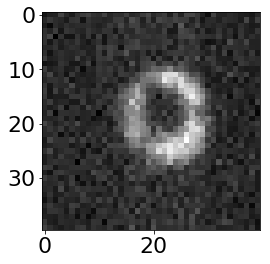

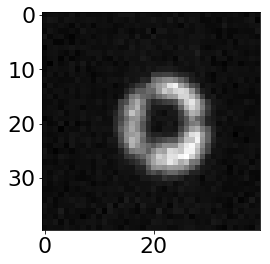

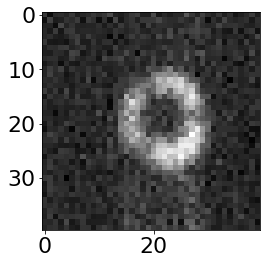

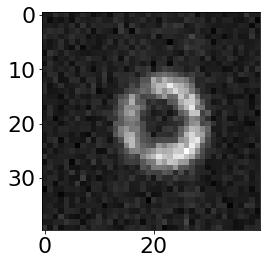

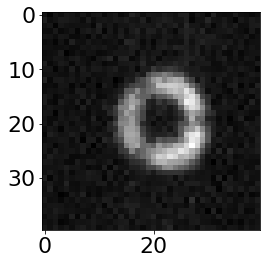

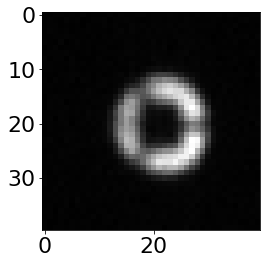

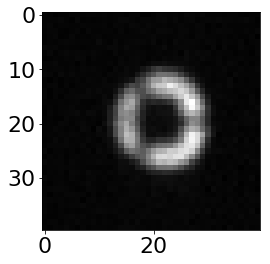

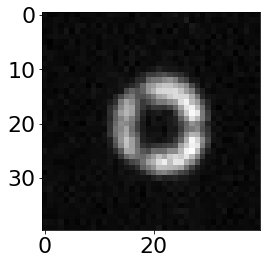

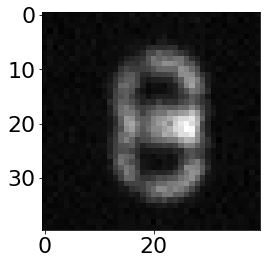

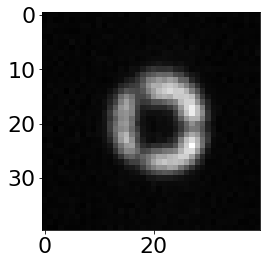

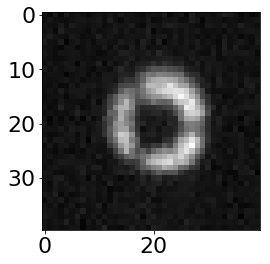

In [143]:
for ima in range(0,len(scidata_cuts12)-1):
    plt.figure()
    plt.imshow(scidata_cuts12[ima], cmap='gray')

In [ ]:
__all__ = ['PupilFactory_Neven', 'Pupil']


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale


class PupilFactory_Neven(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupil array.
                              Note that this may be larger than the actual
                              diameter of the illuminated pupil to
                              accommodate zero-padding.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """
        print(self.u)
        print(self.v)
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    def _cutSquare(self,pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        """
        x21 = int(np.floor(p0[0]-r/2))
        x22 = int(np.ceil(p0[0]+r/2))
        y21 = int(np.floor(p0[1]-r/2))
        y22 = int(np.ceil(p0[1]+r/2))
        pupil[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False

    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False

In [ ]:
class PFSPupilFactory(PupilFactory_Neven):
    """!Pupil obscuration function factory for PFS - work in progress.
    """
    def __init__(self, pupilSize, npix):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory_Neven.__init__(self, pupilSize, npix)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0.43, 0.43]),
                         np.array([0.43, 0.43]),
                         np.array([-0.43, -0.43]),
                         np.array([-0.43, -0.43])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle = 51.75*degrees
        alpha = strutAngle - 45.0*degrees
        unrotAngles = [90*degrees + alpha,
                       -alpha,
                       180*degrees - alpha,
                       270*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    telescopeDiameter = 8.2  # meters

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(np.arctan2(0, 1))
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        subaruRadius = self.telescopeDiameter/2

        hscFrac = 0.231  # linear fraction
        # radius of HSC camera shadow in meters
        hscRadius = hscFrac * subaruRadius

        subaruStrutThick = 0.22  # meters

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 0.00558 * 3600 / 128.9 * subaruRadius
        # Projected radius of lens obstruction in meters
        lensRadius = subaruRadius * 138./128.98

        # Focal plane location in degrees
        hscPlateScale = 0.168  # arcsec/pixel
        thetaX = point.getX() * hscPlateScale / 3600
        thetaY = point.getY() * hscPlateScale / 3600

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        self._cutSquare(pupil, (camX, camY), hscRadius)
        # Cut outer edge where L1 is too small
        lensX = thetaX * lensRate
        lensY = thetaY * lensRate
        self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil

In [ ]:
class ZernikeFitter_PSF(object):
    
    """Description comes here
    """
    def __init__(self, image, pupil, diam, pixelScale=None,
                 jacobian=None,**kwargs):
        """
Description of parameters comes here
        """
        print('init_start')
        self.image = image
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        #pixelScale=geom.Angle(0.000001818)
        #pixelScale=geom.radToArcsec(pixelScale)
        pixelScale=geom.Angle(0.000001118)
        pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        zmax=11
        self.zmax = zmax
        wavelength=6000
        self.wavelength=wavelength
        
        self.aper = galsim.Aperture(
            diam = diam,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = pupil.size)
        self.kwargs = kwargs
        print('init_finished')
    
    def initParams(self, z4Init, z4Range, zRange,
                   centroidRange, fluxRelativeRange):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        print('init_params_start')
        params = lmfit.Parameters()
        params.add('dx', 0.0, min=centroidRange[0], max=centroidRange[1])
        params.add('dy', 0.0, min=centroidRange[0], max=centroidRange[1])
        image = self.image
        flux = float(np.sum(image))
        #self.flux=flux
        params.add('flux', flux,
                   min = fluxRelativeRange[0]*flux,
                   max = fluxRelativeRange[1]*flux)
        params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0, min=zRange[0], max=zRange[1])
        self.params = params
        print('init_params_finish')
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init
        #aberrations = aberrations_init+aber_4_to_11
        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        #There is a part here related to optical properties of telescope....
        # Define the optical part of the PSF:
        # The first argument of OpticalPSF below is lambda/diam (wavelength of light / telescope
        # diameter), which needs to be in the same units used to specify the image scale.  We are using
        # arcsec for that, so we have to self-consistently use arcsec here, using the following
        # calculation:
        #tel_diam = 1.          # meters
        #lam = 1000              # nm    NB: don't use lambda - that's a reserved word.
        #lam_over_diam = lam * 1.e-9 / tel_diam # radians
        #lam_over_diam *= 206265  # arcsec
        #Uncomment below to show lam_over_diam
        #print("wavelenght over diameter of the telescope is "+str(lam_over_diam)+" arcsec" )
        # The rest of the values should be given in units of the wavelength of the incident light.
        return galsim.OpticalPSF(lam=self.wavelength,diam=self.aper.diam, aberrations = aberrations,aper=self.aper)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])*v['flux']
        #pixel scale at the moment choosen at random, made to be same to lam_over_diam
        #pixelScale=geom.Angle(0.000001)
        #pixelScale=geom.radToArcsec(pixelScale)
        #Uncomment below to show pixes scale
        #print("You have set pixel scale to be "+str(pixelScale)+" arcsec")
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        #multiplicative_factor=np.sum(modelImg.array)
        return 1*modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean(chi_without_nan)**2))
        return chi_without_nan
    
    def best_image_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_Neven(self):
        """Do the fit
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit")
        self.result = lmfit.minimize(self._chi_Neven, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)

In [ ]:
%pdb
from lsst.afw.geom import Point2D
HscPupil=PFSPupilFactory(8,100)
point=Point2D(0,0)
HscPupil.getPupil(point)
pupil=HscPupil.getPupil(point)
plt.imshow(HscPupil.getPupil(point).illuminated, cmap='gray')


In [ ]:
#iluminated=HscPupil.getPupil(point)
#iluminated[:4]=0
#iluminated
diam=8.2
pupil=HscPupil.getPupil(point)

aper_test = galsim.Aperture(
            diam = diam,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = pupil.size)

In [ ]:
#ZernikeFitter_PSF takes one image, only used to deduce shape, the pupil and the diameter
single_image_analysis=ZernikeFitter_PSF(scidata_cuts12[5],pupil,diam=8)
single_image_analysis.initParams(z4Init=0.0,z4Range=(0,2),zRange=(-1,1),\
                                 centroidRange=(-5,5),fluxRelativeRange=(0,0.8))

In [ ]:
#Run below only if you really want to fit

In [ ]:
result_fit_single_image=single_image_analysis.fit_Neven()

In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(scidata_cuts12[5], cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(scidata_cuts12[5], cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(best_img, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(best_img, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(residual_img, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(residual_img, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
result_fit_single_image.params

#  <span style="color:red">Which pixels are contributing in the final image?  - deprecated</span>

In [ ]:
kinda_sigma_map=np.sqrt(scidata_cuts12[5])
map_where_chi2=(residual_img/kinda_sigma_map)**2

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(np.nan_to_num(map_where_chi2), cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(np.nan_to_num(map_where_chi2), cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

# Modeling PSF pupil and creating one realistic image

In [6]:
"""
(Re-)Created on Mon Sep 23 18:59 2017

@author: ncaplar@princeton.edu

Goals
1. Creating single pupil
    -using HSC scales
    -using PFS scales 
    
This is done, perhaps not correct roations and movement in focal plane

2. Create a single image which looks kinda like the real data
3. 

"""

'\nCreated on Mon Sep 23 18:59 2017\n\n@author: ncaplar@princeton.edu\n\nGoals\n\n'

In [1]:
from __future__ import absolute_import, division, print_function

import lmfit
import galsim
import numpy as np
import lsst.afw
import astropy

from astropy.io import fits
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D
from matplotlib.colors import LogNorm

import matplotlib
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 22})
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

## Creating single pupil - done, for HSC size

In [8]:
__all__ = ['PupilFactory_Neven', 'Pupil']


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale



class PupilFactory_Neven(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupil array.
                              Note that this may be larger than the actual
                              diameter of the illuminated pupil to
                              accommodate zero-padding.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """
        print(self.u)
        print(self.v)
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        """
        x21 = int(np.floor(p0[0]-r/2))
        x22 = int(np.ceil(p0[0]+r/2))
        y21 = int(np.floor(p0[1]-r/2))
        y22 = int(np.ceil(p0[1]+r/2))
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False

    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        
        
        
class PFSPupilFactory(PupilFactory_Neven):
    """!Pupil obscuration function factory for PFS - work in progress.
    """
    def __init__(self, pupilSize, npix,input_angle):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory_Neven.__init__(self, pupilSize, npix,input_angle)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    telescopeDiameter = 8.3  # meters

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        print(parAng)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        subaruRadius = self.telescopeDiameter/2

        hscFrac = 0.231  # linear fraction
        # radius of HSC camera shadow in meters
        hscRadius = hscFrac * subaruRadius

        subaruStrutThick = 0.22  # meters

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 0.00558 * 3600 / 128.9 * subaruRadius
        # Projected radius of lens obstruction in meters
        lensRadius = subaruRadius * 138./128.98

        # Focal plane location in degrees
        hscPlateScale = 0.168  # arcsec/pixel
        thetaX = point.getX() * hscPlateScale / 3600
        thetaY = point.getY() * hscPlateScale / 3600

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        lensX = thetaX * lensRate
        lensY = thetaY * lensRate
        self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil

0.392699 rad
I am not sure that central square moves properly when moving and rotating on focal plane!!!!!
I am not sure that central square moves properly when moving and rotating on focal plane!!!!!
I am not sure that central square moves properly when moving and rotating on focal plane!!!!!


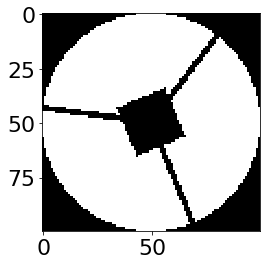

In [9]:
HscPupil=PFSPupilFactory(8.3,100,np.pi/8)
point=Point2D(0,0)
HscPupil.getPupil(point)
pupil=HscPupil.getPupil(point)
plt.imshow(HscPupil.getPupil(point).illuminated, cmap='gray')

## Creating single pupil, PFS size

In [2]:
__all__ = ['PupilFactory_Neven', 'Pupil']


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale



class PupilFactory_Neven(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupil array.
                              Note that this may be larger than the actual
                              diameter of the illuminated pupil to
                              accommodate zero-padding.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False

    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        
        
        
class PFSPupilFactory(PupilFactory_Neven):
    """!Pupil obscuration function factory for PFS - work in progress.
    """
    def __init__(self, pupilSize, npix,input_angle):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory_Neven.__init__(self, pupilSize, npix,input_angle)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    telescopeDiameter = 0.3  # meters

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        print(parAng)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        subaruRadius = self.telescopeDiameter/2

        hscFrac = 0.49  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        subaruStrutThick = 0.012 # meters - current value is basically random

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 0.00558 * 3600 / 128.9 * subaruRadius
        # Projected radius of lens obstruction in meters
        lensRadius = subaruRadius * 138./128.98

        # Focal plane location in degrees
        hscPlateScale = 0.168  # arcsec/pixel
        thetaX = point.getX() * hscPlateScale / 3600
        thetaY = point.getY() * hscPlateScale / 3600

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        lensX = thetaX * lensRate
        lensY = thetaY * lensRate
        #self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil

-0.52 rad
I am not sure that central square moves properly when moving and rotating on focal plane!!!!!


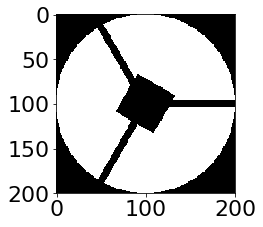

In [91]:
HscPupil=PFSPupilFactory(0.3,200,-0.52)
point=Point2D(0,0)
pupil=HscPupil.getPupil(point)
fig = plt.figure(figsize=(3.2, 10))
plt.imshow(pupil.illuminated, cmap='gray')

## Ok - create array of pupils and "experimentally" deduce which one we need - WIP

In [169]:
"""
(Re-)Created on Mon Sep 23 19:56 2017

@author: ncaplar@princeton.edu


Dependencies:
9.2


Goals

"""

'\n(Re-)Created on Mon Sep 23 19:56 2017\n\n@author: ncaplar@princeton.edu\n\n\nDependencies:\n10.2\n\n\nGoals\n\n'

#Import data 

In [12]:
data=fits.open('/media/caplarn/PFSData/PFS/Data_Sep_15/2017-08-16/v0003617/PFLAr1.fits')
scidata=data[1].data

In [13]:
#Collumns in which there is data
pos_x_of_donuts=np.where(scidata.max(axis=0)>100)
idx = np.where((np.diff(pos_x_of_donuts).ravel()>10)!=False)[0]
idx=np.insert(idx,0,1)
#This gives position of the collumns 
pos_x_of_donuts_subarray=[]
for i in range(len(idx)-1):
    pos_x_of_donuts_subarray=np.append(pos_x_of_donuts_subarray,np.mean(pos_x_of_donuts[0][(idx[i]+1):(idx[i+1]+1)]))
    pos_x_of_donuts_subarray=np.round(pos_x_of_donuts_subarray)
onefiber_x_position=int(pos_x_of_donuts_subarray[5])    
onefiber=scidata[:,onefiber_x_position-20:onefiber_x_position+20]
pos_y_of_donuts=np.where(onefiber.max(axis=1)>50)
idy = np.where((np.diff(pos_y_of_donuts).ravel()>10)!=False)[0]
idy=np.insert(idy,0,1)
#This gives position of rows 
pos_y_of_donuts_subarray=[]
pos_y_of_donuts_subarray_len=[]
for i in range(len(idy)-1):
    pos_y_of_donuts_subarray=np.append(pos_y_of_donuts_subarray,np.mean(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]))
    pos_y_of_donuts_subarray_len=np.append(pos_y_of_donuts_subarray_len,len(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]))
    pos_y_of_donuts_subarray=np.round(pos_y_of_donuts_subarray)

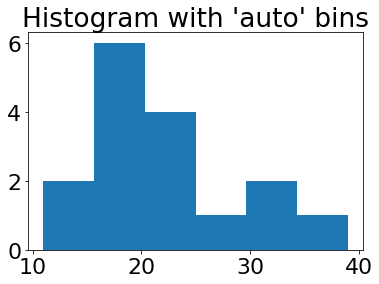

In [14]:
plt.hist(pos_y_of_donuts_subarray_len, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [15]:
#Cutting above 30 pixels in this example (keep the one at 29 pixels just to see what happens)

In [16]:
pos_y_of_donuts_subarray_single_donut=pos_y_of_donuts_subarray[pos_y_of_donuts_subarray_len<30]

In [17]:
scidata_cuts=[[]]
for i in range(len(pos_y_of_donuts_subarray_single_donut)-1):
    single_scidata_cut=onefiber[(int(pos_y_of_donuts_subarray_single_donut[i])-20):(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
    scidata_cuts=np.append(scidata_cuts,single_scidata_cut)

In [18]:
scidata_cuts12=np.split(scidata_cuts,12)
for i in range(len(scidata_cuts12)-1):
    scidata_cuts12[i]=scidata_cuts12[i].reshape(40,40)

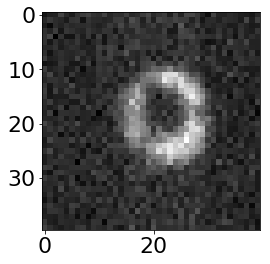

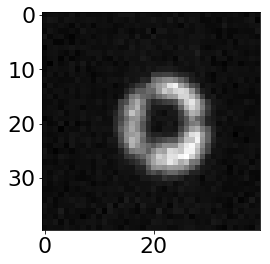

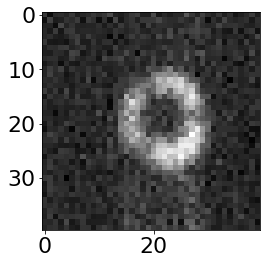

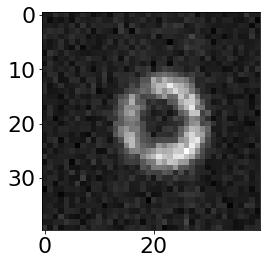

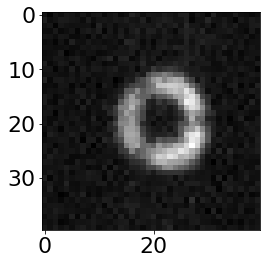

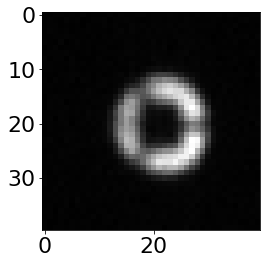

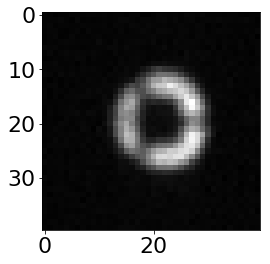

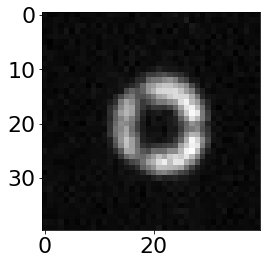

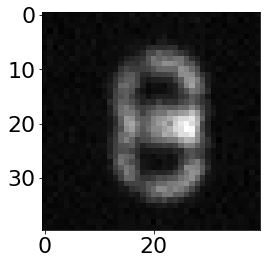

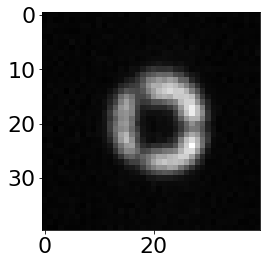

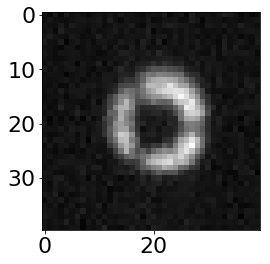

In [19]:
for ima in range(0,len(scidata_cuts12)-1):
    plt.figure()
    plt.imshow(scidata_cuts12[ima], cmap='gray')

#Create fitter

In [92]:
class ZernikeFitter_PSF(object):
    
    """Description comes here
    """
    def __init__(self, image, pupil, diam, pixelScale=None,
                 jacobian=None,**kwargs):
        """
Description of parameters comes here
        """
        self.image = image
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        #pixelScale=geom.Angle(0.000001118)
        #pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        zmax=11
        self.zmax = zmax
        wavelength=300
        self.wavelength=wavelength
        
        self.aper = galsim.Aperture(
            diam = diam,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = pupil.size)
        self.kwargs = kwargs
    
    def initParams(self, z4Init, z4Range, zRange,
                   centroidRange, fluxRelativeRange):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        params = lmfit.Parameters()
        params.add('dx', 0.0, min=centroidRange[0], max=centroidRange[1])
        params.add('dy', 0.0, min=centroidRange[0], max=centroidRange[1])
        image = self.image
        #flux = float(np.sum(image))
        #self.flux=flux
        #params.add('flux', flux,
        #           min = fluxRelativeRange[0]*flux,
        #           max = fluxRelativeRange[1]*flux)
        #params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
        #for i in range(5, self.zmax+1):
        #    params.add('z{}'.format(i), 0.0, min=zRange[0], max=zRange[1])
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init
        #aberrations = aberrations_init+aber_4_to_11
        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        #There is a part here related to optical properties of telescope....
        # Define the optical part of the PSF:
        # The first argument of OpticalPSF below is lambda/diam (wavelength of light / telescope
        # diameter), which needs to be in the same units used to specify the image scale.  We are using
        # arcsec for that, so we have to self-consistently use arcsec here, using the following
        # calculation:
        #tel_diam = 1.          # meters
        #lam = 1000              # nm    NB: don't use lambda - that's a reserved word.
        #lam_over_diam = lam * 1.e-9 / tel_diam # radians
        #lam_over_diam *= 206265  # arcsec
        #Uncomment below to show lam_over_diam
        #print("wavelenght over diameter of the telescope is "+str(lam_over_diam)+" arcsec" )
        # The rest of the values should be given in units of the wavelength of the incident light.
        return galsim.OpticalPSF(lam=self.wavelength,diam=self.aper.diam, aberrations = aberrations,aper=self.aper)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        print(v['flux'])
        psf = psf.shift(v['dx'], v['dy'])*v['flux']
        #pixel scale at the moment choosen at random, made to be same to lam_over_diam
        #pixelScale=geom.Angle(0.000001)
        #pixelScale=geom.radToArcsec(pixelScale)
        #Uncomment below to show pixes scale
        #print("You have set pixel scale to be "+str(pixelScale)+" arcsec")
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        #multiplicative_factor=np.sum(modelImg.array)
        return modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean(chi_without_nan)**2))
        return chi_without_nan
    
    def best_image_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_Neven(self):
        """Do the fit
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit")
        self.result = lmfit.minimize(self._chi_Neven, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)

#Create single mock image

In [93]:
#1. Figure how to create a single reasonable mock image

In [94]:
test_par=lmfit.Parameters()
#opens most generic parameters
file_par=open('/home/caplarn/Documents/PFS/PFS_Work_In_Progress/JSONparameters/0.json',"r")
test_par.load(file_par)
#This set flux in the simulated image to be the same as in the target image
test_par['flux'].set(np.sum(scidata_cuts12[5]))
test_par['z4'].set(1.2)
single_image_analysis=ZernikeFitter_PSF(scidata_cuts12[5],pupil,diam=0.3)

143761.988465
142030.0


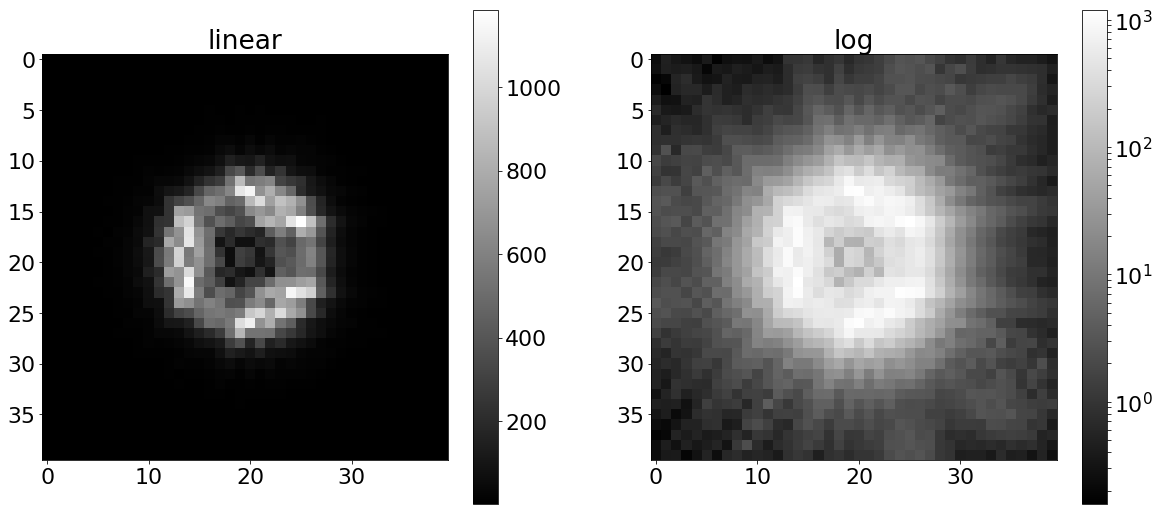

In [95]:
#test_par=result_fit_single_image.params
#I am noticing that this a lot less then in flux parameter
test_img=single_image_analysis.best_image_Neven(test_par)
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(test_img, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(test_img, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

print(np.sum(test_img))

143761.988465


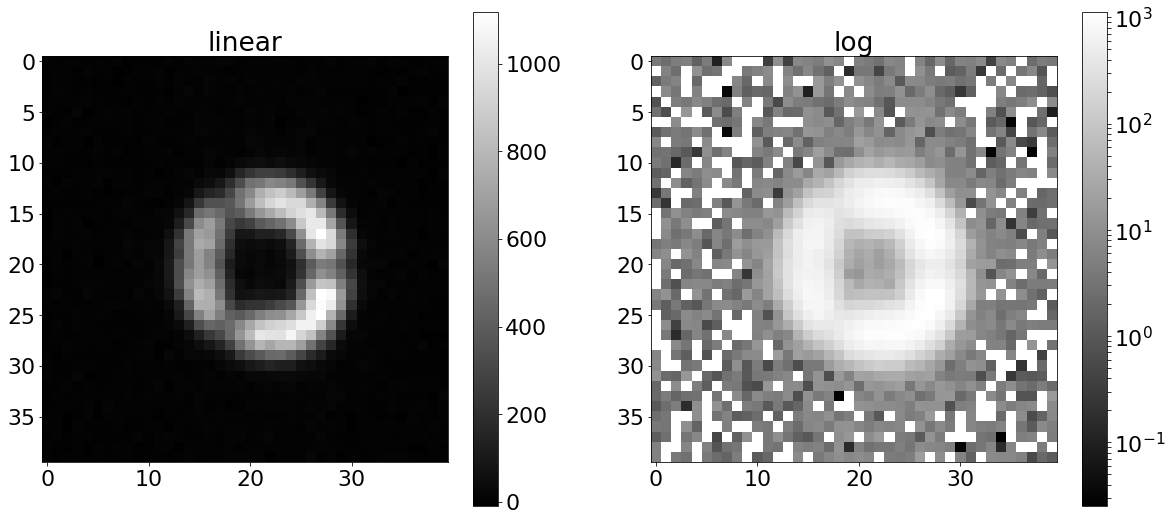

In [26]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(scidata_cuts12[5], cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(scidata_cuts12[5], cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)
print(np.sum(scidata_cuts12[5]))

In [62]:
test_par['z4'].set(1)
test_par

Parameters([(u'dx', <Parameter 'dx', -0.0, bounds=[-5:5]>),
            (u'dy', <Parameter 'dy', -0.0, bounds=[-5:5]>),
            (u'flux',
             <Parameter 'flux', 2189.943716257398, bounds=[0.0:115009.59077219517]>),
            (u'z4', <Parameter 'z4', 1, bounds=[-inf:inf]>),
            (u'z5', <Parameter 'z5', -0.0, bounds=[-1:1]>),
            (u'z6', <Parameter 'z6', -0.0, bounds=[-1:1]>),
            (u'z7', <Parameter 'z7', 0.0, bounds=[-1:1]>),
            (u'z8', <Parameter 'z8', 0.0, bounds=[-1:1]>),
            (u'z9', <Parameter 'z9', 0.0, bounds=[-1:1]>),
            (u'z10', <Parameter 'z10', 0.0, bounds=[-1:1]>),
            (u'z11', <Parameter 'z11', 0.0, bounds=[-1:1]>)])

In [ ]:
#This code can be used to try different paramters
PFSPF1=5
Zernike=1
Defocus=9
img_analyzed=scidata_cuts12[5]
HscPupil=PFSPupilFactory(PFSPF1,100)
point=Point2D(0,0)
HscPupil.getPupil(point)
pupil=HscPupil.getPupil(point)
test_image_analysis=ZernikeFitter_PSF(img_analyzed,pupil,Zernike)
file_par=open('/home/caplarn/Documents/PFS/RandomCode/JSONparameters/'+str(Defocus)+'.json',"r")
test_par = lmfit.Parameters()
test_par.load(file_par)
test_img=test_image_analysis.best_image_Neven(test_par)
plt.figure(figsize=img_analyzed.shape)
plt.subplot(221)
plt.imshow(test_img, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(test_img, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)
#plt.savefig('/home/caplarn/Documents/PFS/RandomCode/Plots/'+str(PFSPF1)+str(Zernike)+str(Defocus)+'.png')

In [ ]:
#This code can be used to try different paramters - many attempts
matplotlib.rcParams.update({'font.size': 36})
for PFSPF1 in range(1,6):
    for Zernike in range(1,6):
        if PFSPF1<=Zernike:
            print('PFSPF1<Zernike')
        else:
            for Defocus in range(1,6):
                img_analyzed=scidata_cuts12[5]
                HscPupil=PFSPupilFactory(PFSPF1,100)
                point=Point2D(1800,1800)
                HscPupil.getPupil(point)
                pupil=HscPupil.getPupil(point)
                test_image_analysis=ZernikeFitter_PSF(img_analyzed,pupil,2)
                file_par=open('/home/caplarn/Documents/PFS/RandomCode/JSONparameters/'+str(Defocus)+'.json',"r")
                test_par = lmfit.Parameters()
                test_par.load(file_par)
                test_img=test_image_analysis.best_image_Neven(test_par)
                plt.figure(figsize=img_analyzed.shape)
                plt.subplot(221)
                plt.imshow(test_img, cmap='gray')
                plt.colorbar()
                plt.title('linear')
                plt.grid(False)
                plt.subplot(222)
                plt.imshow(test_img, cmap='gray',norm=LogNorm())
                plt.colorbar()
                plt.title('log')
                plt.grid(False)
                plt.savefig('/home/caplarn/Documents/PFS/RandomCode/Plots/'+str(PFSPF1)+str(Zernike)+str(Defocus)+'.png')

# Fitting real data on one chip?